In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import decomposition,linear_model
from sklearn.metrics import confusion_matrix,log_loss,roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

In [2]:
#I'm reading in a csv file to a pandas dataframe. 
df=pd.read_csv('/Users/rayparlour/Desktop/cell_data.csv',header=None)
column_names=['id','thickness','unif_size','unif_shape','adhesion','size',
              'nuclei','chromatin','nucleoli','mitosis','class']
#Now I'm going to name the columns. 
df.columns = column_names
#Now I'm going to look at some data. 
df.head()

,id,thickness,unif_size,unif_shape,adhesion,size,nuclei,chromatin,nucleoli,mitosis,class
0,1002945,5,4,4,5,7,10,3,2,1,2\
1,1015425,3,1,1,1,2,2,3,1,1,2\
2,1016277,6,8,8,1,3,4,3,7,1,2\
3,1017023,4,1,1,3,2,1,3,1,1,2\
4,1017122,8,10,10,8,7,10,9,7,1,4\


In [3]:
###First, I need to remove the \'s from the right-most column in our pandas dataframe.
df['class']=df["class"].str.slice(0,1)

In [20]:
df.head()

,id,thickness,unif_size,unif_shape,adhesion,size,nuclei,chromatin,nucleoli,mitosis,class
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


In [4]:
###I'm going to remove the all rows associated with absent nuclei values (i.e. ?'s)
df=df.loc[df['nuclei'] != '?']
df.head()

,id,thickness,unif_size,unif_shape,adhesion,size,nuclei,chromatin,nucleoli,mitosis,class
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


In [5]:
#Now, I'm going to change the data type
df=df.astype(np.int64)

In [6]:
###change malignant code of 4 to 1, just to make things more intuitive. 
df['class'][df['class']==4]=1

In [7]:
###Also, change benign class from 2 to 0
df['class'][df['class']==2]=0

In [8]:
###I'm going to reset the dataframe index. 
df = df.reset_index(drop=True)

In [9]:
###Oh, look. New indexing. 
df.head()

,id,thickness,unif_size,unif_shape,adhesion,size,nuclei,chromatin,nucleoli,mitosis,class
0,1002945,5,4,4,5,7,10,3,2,1,0
1,1015425,3,1,1,1,2,2,3,1,1,0
2,1016277,6,8,8,1,3,4,3,7,1,0
3,1017023,4,1,1,3,2,1,3,1,1,0
4,1017122,8,10,10,8,7,10,9,7,1,1


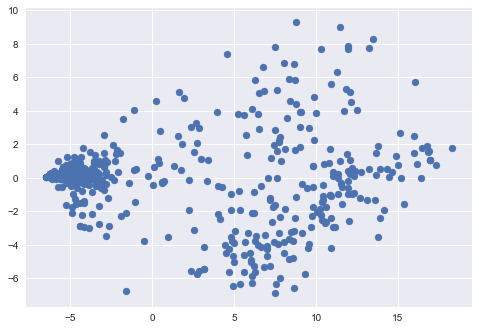

In [10]:
#Here, I'm doing a 2-D PCA of the data, just so I can visualize it all. Not sure this really helped.
#I was initially interested in a logistic regression on PCA axis, but that was not a promising path. 
#But that's not going to stop me from including this code. 
plt.cla()
pca = decomposition.PCA(n_components=2)
pca.fit(df.iloc[:,1:9])
X = pca.transform(df.iloc[:,1:9])
#I'm going to add pca scores to the dataframe. Even though I didn't end up using them. 
df['pca1']=X[:,0]
df['pca2']=X[:,1]
#Here's the plot of the pca scores.
plt.scatter(X[:,0],X[:,1])

In [11]:
#Anyway, the whole PCA-logistic regression thing didn't seem to be promising
#So, I'm going to do a random forest classifier.
#Here, I'm segmenting my data into training, validation, train_valid, and test data. 
X, y = df.iloc[:,1:9], df.iloc[:,10]
X_train, y_train = df.iloc[0:200,1:9], df.iloc[0:200,10]
X_valid, y_valid = df.iloc[201:400,1:9], df.iloc[201:400,10]
X_test, y_test = df.iloc[401:,1:9], df.iloc[401:,10]

In [12]:
# Train random forest classifier
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)
clf_probs = clf.predict_proba(X_test)
#Calibrate on validation data
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(X_valid, y_valid)
# Evaluate on test data
sig_clf_probs = sig_clf.predict_proba(X_test)
sig_score = log_loss(y_test, sig_clf_probs)
sig_score

0.058451397240465455

In [13]:
#Now I can predict the values based on the training dataset. Then I can see how well the model performs. 
Y_pred_rf=clf.predict(X_test)

In [14]:
#Now I'm going to use the test data and the predicted data to generate 
#a confusion matrix (kind of like The Matrix Revolutions, AMIRITE? LOLZLOLZ!!!)
cnf_matrix = confusion_matrix(y_test, Y_pred_rf)
cnf_matrix

array([[212,   3],
       [  1,  65]])

In [15]:
#Calculate the percent correctly classified for the test data
(212+65)/(212+65+3+1)

0.9857651245551602

In [21]:
#Now I get the AUC score
roc_auc_score(y_test, sig_clf_probs[:,1])

0.99830866807610996

In [16]:
#OK, so good AUC score
#Now, I'll calculate the percent correctly classified for ALL the data
Y_pred=clf.predict(X)

In [17]:
cnf_matrix = confusion_matrix(y, Y_pred)
cnf_matrix

array([[431,  12],
       [  5, 234]])

In [18]:
#Now I'm going to calculate the percent correctly classified for all data
(431+236)/(431+236+12+3)

0.9780058651026393

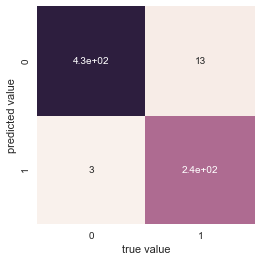

In [79]:
#OK, so 98% accurate overall
#Now I'm going to show a confusion matrix in color, just because. 
sns.heatmap(cnf_matrix, square = True, annot = True, cbar = False) 
plt.ylabel('predicted value') 
plt.xlabel('true value');

In [22]:
###Calculate AUC for entire datset
sig_clf_probs_all = sig_clf.predict_proba(X)
roc_auc_score(y, sig_clf_probs_all[:,1])

0.99518781227273156

In [27]:
rc=roc_curve(y, Y_pred)

In [36]:
#Now I want to see what predictor variables were important. Here's the variables:
df.columns[1:9]

Index(['thickness', 'unif_size', 'unif_shape', 'adhesion', 'size', 'nuclei',
       'chromatin', 'nucleoli'],
      dtype='object')

In [35]:
#Here's the feature importances 
clf.feature_importances_

array([ 0.11237541,  0.2569272 ,  0.17533937,  0.10308251,  0.14780565,
        0.11012768,  0.03510515,  0.05923702])